In [56]:
show_plots = True

In [57]:
import sys # for automation and parallelization
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])
if manual:
    %matplotlib inline

In [58]:
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame, GeoSeries
import shapely
from shapely.ops import unary_union
from shapely.geometry import Point, LineString, MultiPolygon, Polygon
from quetzal.model import stepmodel
import matplotlib.pyplot as plt
import numpy as np
import time
import math


In [59]:
# import helper functions 
# imports all helper functions stored in class "helpers" 
%run -i helperFunctions.py

<Figure size 432x288 with 0 Axes>

# Create zones and add basic information
## Zones Berliner Ortsteile, number of inhabitants 
Uses Berliner Ortsteile (n=98), source: https://fbinter.stadt-berlin.de/fb/wfs/data/senstadt/s_wfs_alkis_ortsteile

Population data on bulding block level 2021, source: 

In [60]:
input_path = './../../input/'
output_path = './../../output/'
model_path = './../../model/'

## Zones

Load zone data from the input files

use default espg = 4326

In [61]:
epsg = 4326
zone_ref = 'plr'# 'plr', 'ortsteile', 'k_means

use_k_means = zone_ref == 'k_means'

### read in Berliner Ortsteile shapefile

In [62]:
ortsteile = gpd.read_file(input_path + "zones/Berliner_Ortsteile.shp")
ortsteile = ortsteile.to_crs(epsg=epsg)

dpl 110000030309 len ortsteile 98
len ortsteile 97 False


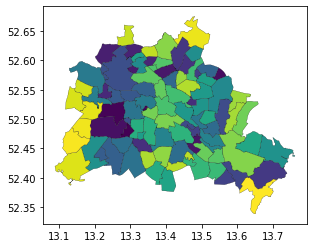

In [63]:
# remove duplicate zone entry (Buch) 
sch = ortsteile['sch']
dpls = list(sch[sch.duplicated()])
for dpl in dpls:
    print("dpl",dpl, "len ortsteile", len(ortsteile))
    ortsteile['geometry'][sch == dpl][0] = unary_union([x for x in ortsteile['geometry'][sch == dpl]])
    blIndex = [True if (not s == dpl) or (not dpl in list(sch.iloc[:n])) else False for n, s in enumerate(sch)]
    ortsteile = ortsteile[blIndex]
    print("len ortsteile", len(ortsteile), all(blIndex))

sch = ortsteile['sch']
if len(list(sch[sch.duplicated()])) > 0:
    print("duplicates:", list(sch[sch.duplicated()]))

if show_plots: ortsteile.plot(cmap="viridis", edgecolor="black", linewidth=0.2)


### read in Planungsraueme shapefile

448


,BEZIRKSNAM,PLANUNGSRA,DATUM_GUEL,FLAECHENGR,broker Dow,geometry
broker Dow,,,,,,
01011101,Mitte,Stülerstraße,14.06.2006,366755.50,01011101,"POLYGON ((13.33889 52.50542, 13.33986 52.50562..."
01011102,Mitte,Großer Tiergarten,14.06.2006,3009397.45,01011102,"POLYGON ((13.33140 52.51288, 13.33141 52.51285..."
01011103,Mitte,Lützowstraße,14.06.2006,522356.58,01011103,"POLYGON ((13.34923 52.50307, 13.34972 52.50343..."
01011104,Mitte,Körnerstraße,14.06.2006,338383.45,01011104,"POLYGON ((13.36254 52.49966, 13.36265 52.49989..."
01011105,Mitte,Nördlicher Landwehrkanal,14.06.2006,934609.72,01011105,"POLYGON ((13.35159 52.50976, 13.35199 52.50978..."


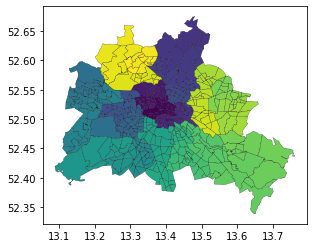

In [64]:
plr = gpd.read_file(input_path + "zones/lor_planungsraeume")

plr.to_crs(epsg=epsg, inplace=True)
if show_plots: plr.plot(cmap="viridis", edgecolor="black", linewidth=0.2)
# fix mistake from shapefile: 04030417 Schloßstraße (04 Charlottenburg-Wilmersdorf) is wrongly labeled as 06010102 Schloßstraße (06 Steglitz-Zehlendorf)
plr['broker Dow'][(plr['broker Dow']=='06010102') & (plr['BEZIRKSNAM']=='Charlottenburg-Wilmersdorf')] = '04030417'
plr.set_index(plr['broker Dow'], inplace=True)
print(len(plr))
plr.head()

### set planungsraeume as reference zones

In [65]:
zones = plr.copy() if zone_ref == 'plr' else ortsteile if zone_ref == 'ortsteile' else None
hull = unary_union([x.buffer(1e-3) for x in zones['geometry']])
hull_gs = GeoSeries([hull], crs=epsg)

### read in Umweltzone (SBahn Ring)

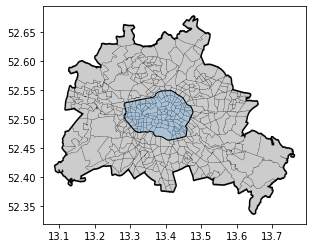

In [66]:
umweltzone = gpd.read_file(input_path + "zones/Umweltzone_-_Berlin")
umweltzone = umweltzone.to_crs(epsg=epsg)
umweltzone_geom = umweltzone['geometry'].iloc[0]
if show_plots: umweltzone.plot(color="#2299ff33", edgecolor="black", linewidth=1, ax=zones.plot(color="#cccccc", edgecolor="black", linewidth=0.2, ax=hull_gs.plot(color="None", edgecolor="black", linewidth=2)))

### read and clean in building block shapefile

In [67]:
# Add building block shapefile
blocks = gpd.read_file(input_path + "zones/Einwohnerdichte_2021.shp")
blocks.to_crs(epsg=epsg, inplace=True)
# remove blocks without geometry property
print("removing", sum(blocks.geometry == None), 
      "blocks with",
      round(sum(blocks[blocks.geometry == None]["ew2021"])),
      "inhabitants due to lack of geometry, e.g. block with schl5 =",
     blocks[blocks.geometry == None].iloc[0]["schl5"] if len(blocks[blocks.geometry == None])>0 else '')
blocks = blocks[blocks.geometry != None]
blocks = blocks[blocks['ew2021'] > 0]
blocks["zone"] = None

# add information whether block in umweltzone or not
blocks['umweltzone'] = [x.intersects(umweltzone['geometry'].iloc[0]) for x in blocks['geometry']]


removing 0 blocks with 0 inhabitants due to lack of geometry, e.g. block with schl5 = 


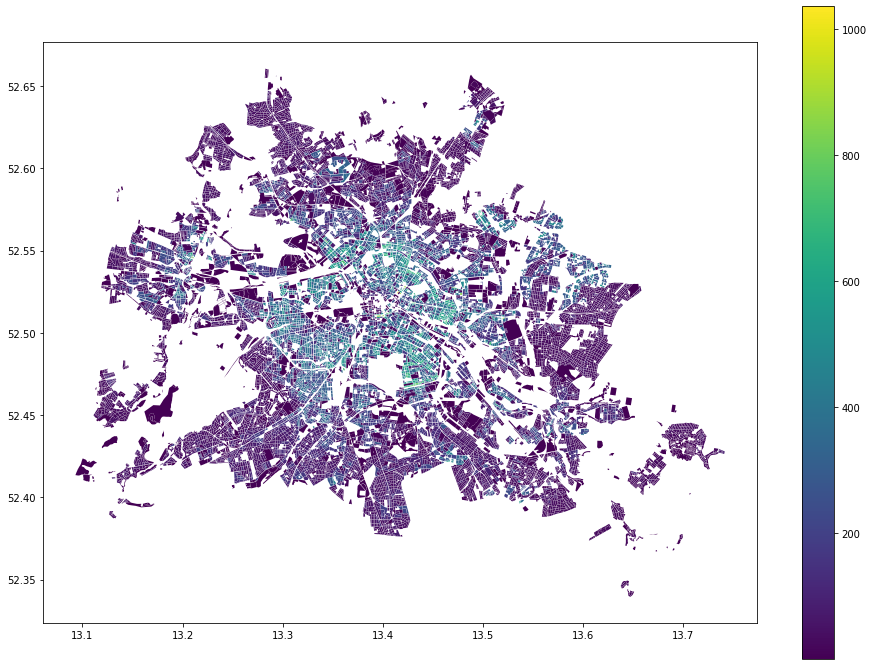

In [68]:
if show_plots:
    fig, ax = plt.subplots(figsize = (16,12))
    blocks.plot(ax=ax, column='ew_ha_2021', cmap = "viridis", legend=True)

### assign a zone to each block (no longer necessary as zones originate from building block cluster assignment)

In [69]:
# assign zone to each block
blocks["zone"] = \
    blocks['geometry']\
        .apply(lambda g: zones.index[zones.intersects(g.centroid)])\
        .apply(lambda zi: zi[-1] if len(zi)>0 else None)

# zones that haven't been matched to a building
zones[[i not in list(blocks["zone"]) for i in zones.index]]

,BEZIRKSNAM,PLANUNGSRA,DATUM_GUEL,FLAECHENGR,broker Dow,geometry
broker Dow,,,,,,
04020314,Charlottenburg-Wilmersdorf,Messegelände,14.06.2006,897271.03,04020314,"POLYGON ((13.26230 52.50720, 13.26254 52.50737..."


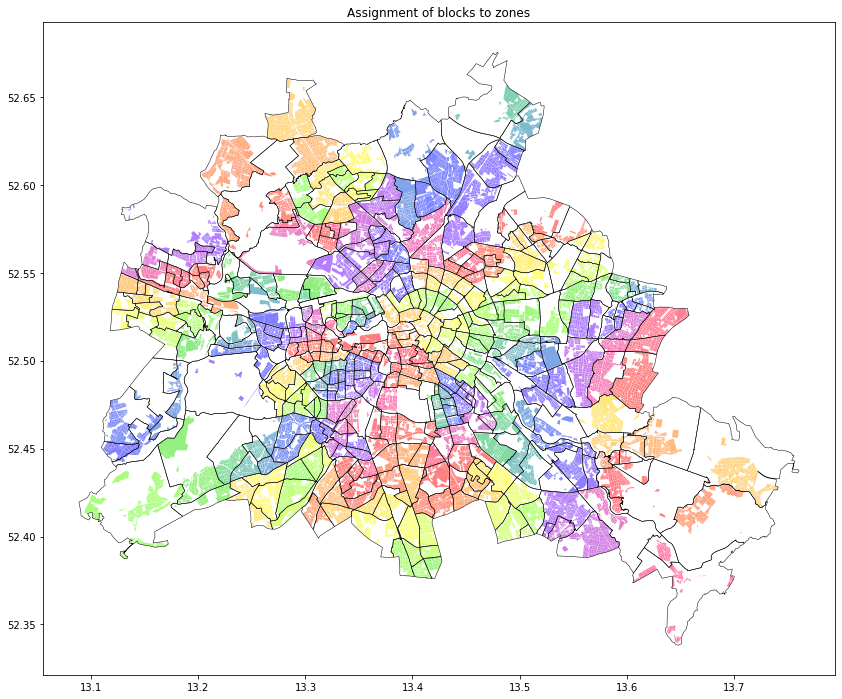

In [70]:
if show_plots:
    # plot
    fig, ax = plt.subplots(figsize = (16,12))
    blocks.plot(ax=ax, column='zone', cmap = "prism", alpha=.5)
    zones.plot(ax=ax, color="None", edgecolor="black", linewidth=0.5)
    ax.set_title("Assignment of blocks to zones")

# cluster building blocks to zones using k_means algorithm

In [71]:
if use_k_means and show_plots:
    fig, ax = plt.subplots(figsize = (16,12))
    blocks.plot(ax=ax, column='umweltzone', cmap = "viridis", legend=True)

In [72]:
if use_k_means:
    # create start points as grid for clustering algorithm
    n_x = 30
    n_y = n_x
    bounds = zones.total_bounds # can also be hull.bounds
    x_min, y_min, x_max, y_max = bounds[0], bounds[1], bounds[2], bounds[3]
    x_step = (x_max-x_min)/n_x
    y_step = (y_max-y_min)/n_y
    bounds
    grid = [item for sublist in [[Point(x_min+x_step*(i_x+i_y%2/2), y_min+i_y*y_step, ) for i_y in range(n_y+1)] for i_x in range(n_x+1)] for item in sublist]
    grid = gpd.GeoSeries(grid, crs=epsg)
    grid_brandenburg = grid[[not x for x in grid.within(hull)]]
    grid = grid[[x for x in grid.within(hull)]]
    grid_umweltzone = grid[[x for x in grid.within(umweltzone_geom)]]
    grid_non_umweltzone = grid[[not x for x in grid.within(umweltzone_geom)]]
    grid = grid[grid.within(hull)]
    grid.index = range(len(grid))

In [73]:
if use_k_means and show_plots:
    fig, ax = plt.subplots(figsize = (12,12))
    grid_brandenburg.plot(ax=ax, color="#cccccc")
    gpd.GeoSeries(hull, crs=epsg).plot(ax=ax, color="None", edgecolor="black", linewidth=2)
    zones.plot(ax=ax, color="None", edgecolor="black", linewidth=0.5)
    grid_umweltzone.plot(ax=ax, color="green")
    grid_non_umweltzone.plot(ax=ax, color="blue")
    umweltzone.plot(ax=ax, color="None", edgecolor="black", linewidth=2)
    ax.set_title("grid_umweltzone: " + str(len(grid_umweltzone)) + ', grid_non_umweltzone: ' + str(len(grid_non_umweltzone)))

## create zone geometries starting from building block cluster assignment

In [74]:
if use_k_means:
    t = time.time()

    show_plots_here = show_plots and True
    if show_plots_here:
        zones_geoms_at_iteration = [blocks]

    # gradually increase a buffer around polygons to match the area not covered by buildings to zones
    # choose starting buff_param and buff_increase as small as feasible to increase precision.

    # if this method is too slow one could implement grid search.

    buff_param, buff_increase, only_polygons, clean_geoms, ease_boders = 0.0005, 0.0005, False, False, False

    # To-Do data on this shoul be already available from cluster algorithm
    zones['umweltzone'] = [list(blocks['umweltzone'][blocks['zone'] == i])[0] for i in zones.index] 

    # divide into outside umweltzone and inside umweltzone
    zone_free_area = [MultiPolygon([hull.difference(umweltzone_geom)]), MultiPolygon([umweltzone_geom])]

    # save a copy of intial geometry to apply buffer. As applying buffer to geom with buffer increases the complexity.
    initial_zone_geoms = [unary_union(list(blocks['geometry'][blocks['zone'] == i])).buffer(buff_param) for i in zones.index]
    zones['geometry'] = initial_zone_geoms
    # stop only when all area has been devided among zones
    islands = []
    it=0
    while not all([x.is_empty for x in zone_free_area]):
        print(buff_param, len(islands), 'of', len(zones), 'complexity zones:', 
        sum([sum([len(z.exterior.coords) + sum([len(y.coords) for y in z.interiors]) for z in x]) if type(x) == MultiPolygon else (len(x.exterior.coords) + sum([len(y.coords) for y in x.interiors]) ) for n, x in enumerate(zones['geometry']) if n not in islands]),    
        '(', sum([len(x) if type(x) == MultiPolygon else 1 for n, x in enumerate(zones['geometry']) if n not in islands]),')',
        'complexity zone free area:', 
        sum([sum([len(z.exterior.coords) + sum([len(y.coords) for y in z.interiors]) for z in x]) for x in zone_free_area]),
        '(', sum([len(x) for x in zone_free_area]),')',
        'time:', round(time.time()-t,2))
        t = time.time()


        for n, zone_geom, inital_zone_geom, umweltzone_bool in zip(zones.index, zones['geometry'], initial_zone_geoms, zones['umweltzone']):
            if n in islands:#zone_free_area[umweltzone_bool].is_empty
                continue
            
            geo_dict = {
                'index': [n for n,x in enumerate(zone_free_area[umweltzone_bool]) if x.intersects(zone_geom)], 
                'intsctns':[], 
                'diffs': []
                }
            
            # if that zone did at one point not touch neutral area it means that its fully surrounded by other areas assigned to zones
            # thus one can jump to next
            if len(geo_dict['index'])==0:
                islands.append(n)
                continue

            buffed_zone = \
                unary_union([x.buffer(buff_param) for x in inital_zone_geom])\
                if type(inital_zone_geom) == MultiPolygon else \
                inital_zone_geom.buffer(buff_param)
            
            # only assign are that has been touching to zones to prevent
            for i_neutral in list(geo_dict['index']):
                intsctn = buffed_zone.intersection(zone_free_area[umweltzone_bool][i_neutral])
                geo_dict['intsctns'].append(intsctn)
                # if not intsctn.is_empty:
                diff = zone_free_area[umweltzone_bool][i_neutral].difference(buffed_zone)
                geo_dict['diffs'].append(diff)
            
            zones['geometry'].iloc[n] = unary_union([zone_geom]+geo_dict['intsctns'])
            
            zone_free_area[umweltzone_bool] = \
                unary_union(\
                    [geo_dict['diffs'][geo_dict['index'].index(i)] \
                    if i in geo_dict['index'] else poly \
                    for i, poly in enumerate(zone_free_area[umweltzone_bool])])
            if not type(zone_free_area[umweltzone_bool]) == MultiPolygon:
                zone_free_area[umweltzone_bool] = MultiPolygon([zone_free_area[umweltzone_bool]])
        
        buff_param += buff_increase
        it+=1
        if show_plots_here:
            zones_geoms_at_iteration.append(zones.copy())

    # clean geometries: just take polygons (no multipolygons)
    zones['geometry'] = [x.intersection(hull) for x in zones['geometry']]

    if only_polygons:
        zones['geometry'] = [max(x, key=lambda a: a.area) if type(x) == MultiPolygon else x for x in zones['geometry']]

    if clean_geoms:
        zones['geometry'] = [x.difference(unary_union(list(zones['geometry'][:n]))) for n, x in enumerate(zones['geometry'])]

    if ease_boders:
        0# not implemented yet.

    print("done.")

In [75]:
if use_k_means and show_plots_here:
    fig, ax = plt.subplots(nrows=math.ceil(math.sqrt(len(zones_geoms_at_iteration)+1)), ncols=math.floor(math.sqrt(len(zones_geoms_at_iteration)+1)), figsize = (20,45))
    for n, a in enumerate(ax.flat):
        if n >= len(zones_geoms_at_iteration):
            fig.delaxes(a) ## delete if nothing is plotted in the axes obj
            continue        

        a.set_title('Iteration: ' + str(n))
        if n == 0:
            zones_geoms_at_iteration[n].plot(ax=ax.flat[0], color = "green", alpha=0.2)
        else:
            gpd.GeoSeries(hull, crs=epsg).plot(ax=a, color="None", edgecolor="black", linewidth=2)
            zones_geoms_at_iteration[n].plot(ax=a, cmap = "viridis", alpha=0.5)
            zones_geoms_at_iteration[n].plot(ax=a, color = "None", edgecolor="black", linewidth=0.25)
            umweltzone.plot(ax=a, color="None", edgecolor="black", linewidth=2)

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (20,20))
    zones.plot(ax=ax, cmap = "viridis", alpha=0.5)
    zones.plot(ax=ax, color = "None", edgecolor="black", linewidth=0.25)

## Initialize stepmodel with zones

In [76]:
# Create the model with Coordinate Reference System epsg
sm = stepmodel.StepModel(epsg=epsg, coordinates_unit='degree')
# Save zones into the model
sm.zones = zones

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 100%. Minutes elapsed: 00:09. Minutes remaining: 00:00. 

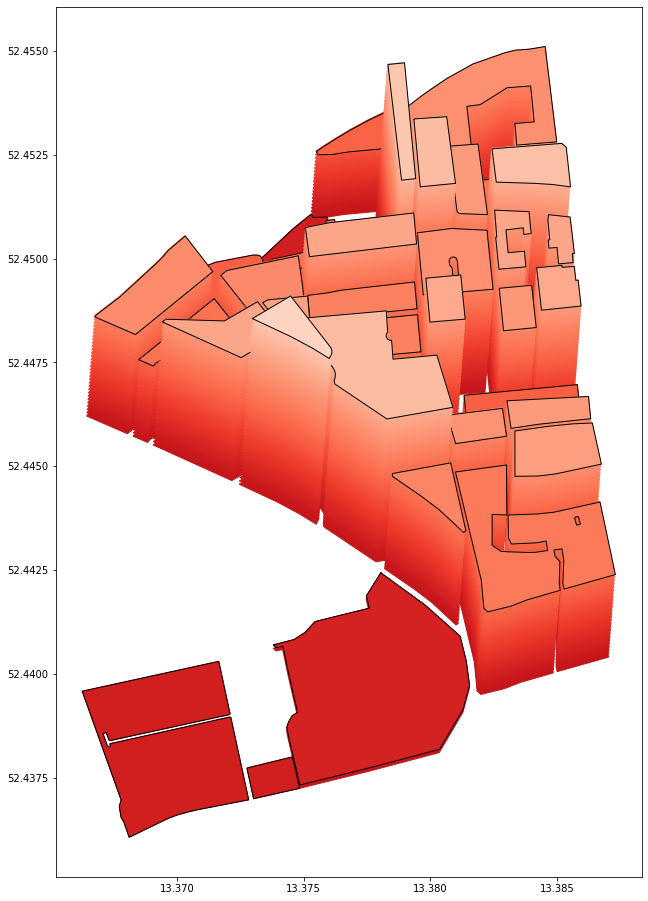

In [77]:
if show_plots:
    # some map art

    from shapely.affinity import translate
    from shapely.ops import unary_union
    import time
    # sf = ["Prenzlauer Berg"]#["Pankow", "Prenzlauer Berg", "Mitte"]
    # spb = blocks[blocks["zone"].isin(sm.zones.index[sm.zones["nam"].isin(sf)])]
    
    spb = blocks[blocks["zone"].isin([sm.zones.index[67+97*2%len(sm.zones)]])]
    bspb = unary_union(list(spb.geometry.apply(lambda g: g.buffer(0.1))))
    bspb = Polygon(bspb.exterior.coords)

    fig, ax = plt.subplots(figsize = (16,16))
    t0 = time.time()

    # sm.road_links.geometry[list(sm.road_links.intersects(bspb))].apply(lambda g: g.buffer(0.00022).intersection(bspb)).plot(ax=ax, color ="grey")


    maxHeight = max(spb["ew_ha_2021"])

    nSteps = 50
    cbuff = 40
    cmap = plt.get_cmap('Reds_r', nSteps + cbuff)

    for i in range(0,nSteps+1):
        # spb["geometry"] = spb.apply(lambda row : translate(row["geometry"], 1,8) if (row["ew_ha_2021"] >= i/nSteps*maxHeight) else None, axis = 1)
        spb["geometry"] = spb.apply(lambda row : translate(row["geometry"], 0.00001,0.00008) if (row["ew_ha_2021"] >= i/nSteps*maxHeight) else None, axis = 1)
        spb.plot(ax=ax, color = cmap(round(i + 0.5*cbuff)), edgecolor = cmap(round(i + 0.5*cbuff)), linewidth = 1)
        last = spb.apply(lambda row : None if (row["ew_ha_2021"] >= (i+1)/nSteps*maxHeight) else row["geometry"], axis = 1)
        if any([not x == None for x in last])>0: 
            GeoSeries(last, crs=spb.crs).plot(ax=ax, color = cmap(round(i + 0.5*cbuff+4)), edgecolor = 'black', linewidth = 1)
        # spb.plot(ax=ax, column='ew_ha_2021', cmap = "viridis", linewidth = 2)
        helpers.printProgress(i=i, imax=nSteps, t=time.time(), t0=t0)



### for each zone: sum up population from blocks and create centroids weighted by population

In [78]:
print(blocks['ew2021'].max(), blocks['ew2021'].mean().round(), blocks['ew2021'].min())

5653.0 252.0 3.0


popCentroid (13.212858019592474, 52.564534542419885) not within polygon for zone 05010101 PLANUNGSRA    Hakenfelde Nord
Name: 05010101, dtype: object
popCentroid (13.166370493106127, 52.531250445739026) not within polygon for zone 05020417 PLANUNGSRA    Staakener Straße
Name: 05020417, dtype: object
popCentroid (13.63734046068387, 52.371798928625005) not within polygon for zone 09031202 PLANUNGSRA    Schmöckwitz/Rauchfangswerder
Name: 09031202, dtype: object
popCentroid (13.228214302480403, 52.580579171861594) not within polygon for zone 12224229 PLANUNGSRA    Konradshöhe/Tegelort
Name: 12224229, dtype: object


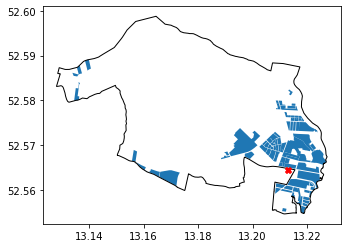

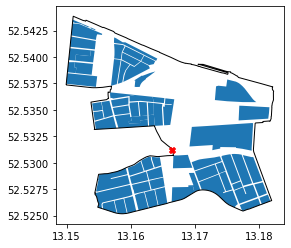

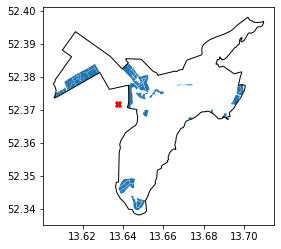

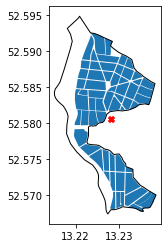

In [79]:
# t0=time.time()
# sum up population from blocks to each zone and create centroids weighted by population
sm.zones["pop"] = 0
sm.zones["popCentroid"] = Point(0.0,0.0)
sm.zones["popCentroidOffset"] = LineString([Point(0.0,0.0), Point(0.0,0.0)])
sm.zones["popCentroidLat"] = 0.0
sm.zones["popCentroidLon"] = 0.0

for zoneIndex, zone in sm.zones.iterrows():
    geom_centroid = zone["geometry"].centroid
    blocksInZone = blocks[blocks["zone"]==zoneIndex]
    
    # obtain total zone population and save to sm.zones
    zonePopulation2021 = sum(blocksInZone["ew2021"])
    sm.zones.at[zoneIndex, "pop"] = zonePopulation2021
    
    # create weighted centroids based on where most people live within 
    weigthedCoords = {"lat": 0, "lon": 0}
    for blockIndex, block in blocksInZone.iterrows():
        weigthedCoords["lon"] += block["ew2021"] / zonePopulation2021 * block["geometry"].centroid.x
        weigthedCoords["lat"] += block["ew2021"] / zonePopulation2021 * block["geometry"].centroid.y
    
    sm.zones.at[zoneIndex, "popCentroidLat"] = weigthedCoords["lat"]
    sm.zones.at[zoneIndex, "popCentroidLon"] = weigthedCoords["lon"]
    popCentroid = Point(weigthedCoords["lon"], weigthedCoords["lat"])
    if len(blocksInZone) == 0:
        popCentroid = geom_centroid
    # check whether those centroids which are not within zone are still plausible
    if(not popCentroid.intersects(zone["geometry"])):
        print("popCentroid", popCentroid.coords[0], "not within polygon", "for zone", zoneIndex, zone[[x for x in ['PLANUNGSRA', "nam"] if x in zone.keys()]])
        if len(blocksInZone) > 0: GeoSeries(popCentroid, crs=sm.epsg).plot(ax=GeoSeries(zone['geometry'], crs=sm.epsg).plot(ax=blocksInZone.plot(), color="None", edgecolor='black'), marker="X", color="red")
    
    sm.zones.loc[zoneIndex, "popCentroid"] = popCentroid
    # add a line between actual centroid and pop centroid
    sm.zones.loc[zoneIndex, "popCentroidOffset"] = LineString([geom_centroid, popCentroid])
    # helpers.printProgress(i=zoneIndex, imax=len(sm.zones), t=time.time(), t0=t0)

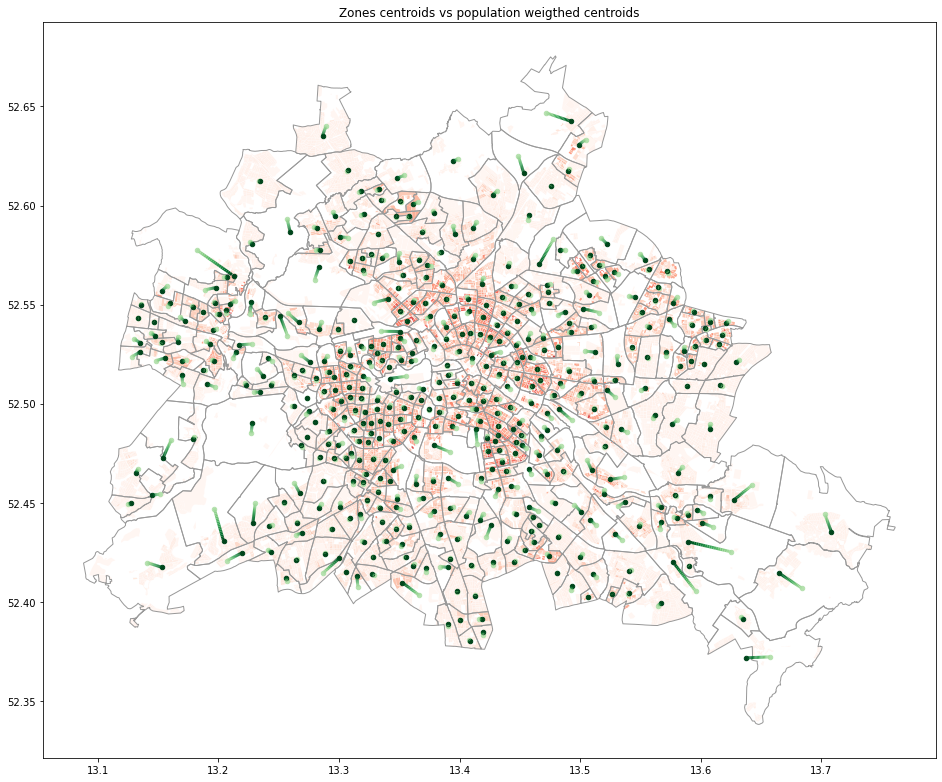

In [80]:
if show_plots:
    # show zones and popCentroids and their offsets from real geometrical centroids
    fig, ax = plt.subplots(1, 1, figsize=(16,16))
    blocks.plot(ax=ax, column='ew_ha_2021', cmap = "Reds")
    # add zone borders and a bit of opacity
    sm.zones.geometry.plot(ax=ax, color = "#ffffff33", edgecolor="#999999")
    nSteps = 20
    cbuff = 10
    cmap = plt.get_cmap('Greens_r', nSteps + cbuff)
    gpd.GeoSeries(sm.zones.geometry.centroid, crs=sm.epsg).plot(ax=ax, color = cmap(nSteps), markersize = 20)
    for i in range(1,nSteps):
        l = [helpers.segmentLine(x, i, nSteps) for x in sm.zones.popCentroidOffset]
        gpd.GeoSeries(l, crs=sm.epsg).plot(ax=ax,color=cmap(i), linewidth=3)
    gpd.GeoSeries(sm.zones.popCentroid, crs=sm.epsg).plot(ax=ax, color = cmap(0), markersize = 20)
    ax.set_title("Zones centroids vs population weigthed centroids")

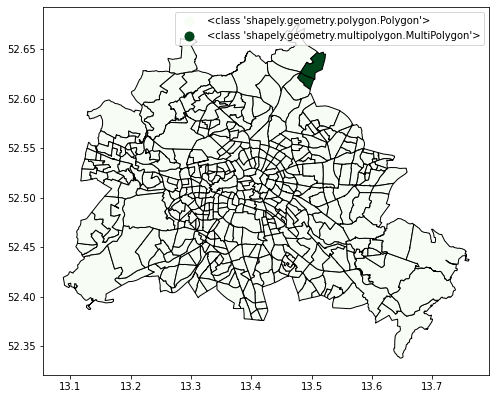

In [81]:
if show_plots:
    # plot zones by geometry type
    sm.zones.plot(column = np.array([type(x) for x in sm.zones["geometry"]]),  cmap = "Greens",  edgecolor="black", legend=True, figsize = (8,8))

# Add zone statistics weighted by population or block square meters


## Add employment data (based on data for planungsraeume and bezirke)

In [82]:
blocks.head(2)

,schl5,ew2021,flalle,ew_ha_2021,typklar,geometry,zone,umweltzone
2,0100980011000300,18.0,5603.764396,32.12,Geschosswohnungsbau der 1990er Jahre und jünger,"POLYGON ((13.36732 52.53556, 13.36693 52.53592...",01011301,True
3,0100980021000200,842.0,34344.730303,245.16,"Heterogene, innerstädtische Mischbebauung, Lüc...","POLYGON ((13.36909 52.53557, 13.36880 52.53583...",01011301,True


0 bis unter 10: 2.0 10 bis unter 50: 26.0 50 bis unter 250: 130.0 250 und mehr: 270.0


In [89]:
# read in employment data and create best guess for each plr employment
# only number of Niederlassungen per plr per Beschäftiungsgrößenklassen is given
employment = pd.read_excel(input_path + 'unternehmen_plr.xlsx')

plr['Bezirk'] = [employment['Bezirk'][employment['broker Dow'] == int(p)].iloc[0] for p in plr['broker Dow']]

# create guess for total employment per plr: 2/3 lower bound + 1/3 upper bound
employment['guess'] = \
    employment['0 bis unter 10'] * (0*80+10*20)/100 + \
    employment['10 bis unter 50'] * (10*60+50*40)/100 + \
    employment['50 bis unter 250'] * (50*60+250*40)/100 + \
    employment['250 und mehr'] * (250*60+300*40)/100
print('0 bis unter 10:', (0*80+10*20)/100, '10 bis unter 50:', (10*60+50*40)/100, '50 bis unter 250:', (50*60+250*40)/100, '250 und mehr:',(250*60+300*40)/100)
# create bezirke gdf based on information of employment data
bezirke = gpd.GeoDataFrame(
    {'Bezirk': employment['Bezirk'].unique()}, 
    geometry=[unary_union([x.buffer(0.0001) for x in plr['geometry'][plr['Bezirk']==b]]) for b in plr['Bezirk'].unique()], 
    crs=sm.epsg
    )
bezirke['guess_sum'] = [sum(employment['guess'][employment['Bezirk']==b]) for b in bezirke['Bezirk']]
bezirke['real_employment'] = [employment['Beschaeftige Bezirk'][employment['Bezirk']==b].iloc[0] for b in bezirke['Bezirk']]
bezirke['correction_factor'] = bezirke['real_employment'] / bezirke['guess_sum']
print('correction_factor', [round(x,2) for x in bezirke['correction_factor']], sum([round(x,2) for x in bezirke['correction_factor']])/len(bezirke))

# apply correction factor to guess
employment['corrected_guess'] = employment.apply(lambda row: (row['guess'] * bezirke['correction_factor'][bezirke['Bezirk'] == row['Bezirk']]).iloc[0], axis=1)
# employment = gpd.GeoDataFrame(employment, geometry=

correction_factor [1.27, 1.02, 0.94, 0.94, 1.16, 0.99, 0.99, 0.86, 0.97, 0.98, 0.96, 1.04] 1.01


In [90]:
# assign zone to each blocksum
blocks["plr"] = \
    blocks['geometry']\
        .apply(lambda g: plr.index[plr.intersects(g.centroid)])\
        .apply(lambda zi: zi[-1] if len(zi)>0 else None)

blocks['area_calc'] = [x.area for x in blocks['geometry']]

# sum total are of blocks within plr
plr['block_area_calc'] = [sum(blocks['area_calc'][blocks['plr']==i]) for i in plr.index]

# calculate share of each block area in plr area 
blocks['plr_share'] = [a/plr['block_area_calc'][plr.index==p][0] if not p==None else 0 for p,a in zip(blocks['plr'], blocks['area_calc'])]
print("should be all around 1.00:", 
    min([sum(blocks['plr_share'][blocks['plr']==i]) for i in plr.index if i in list(blocks['plr'])]), 
    max([sum(blocks['plr_share'][blocks['plr']==i]) for i in plr.index]))
print("plr not included:", [x for x in plr.index if x not in list(blocks['plr'])])

should be all around 1.00: 0.999999999999999 1.000000000000001
plr not included: ['04020314']


In [127]:
# now obtain employment guess for each block 
blocks['plr_employment'] = [employment['corrected_guess'][employment['broker Dow']==int(p)].iloc[0] if not p==None else 0 for p in blocks['plr']]
blocks['employment'] = blocks['plr_employment'] * blocks['plr_share']
blocks['plr_employment_guess'] = [employment['guess'][employment['broker Dow']==int(p)].iloc[0] if not p==None else 0 for p in blocks['plr']]
blocks['employment_guess'] = blocks['plr_employment_guess'] * blocks['plr_share']
# now sum data from building block level to zone level
sm.zones['emp'] = [sum(blocks['employment'][blocks['zone']==i]) for i in sm.zones.index]
sm.zones['emp_guess'] = [sum(blocks['employment_guess'][blocks['zone']==i]) for i in sm.zones.index]


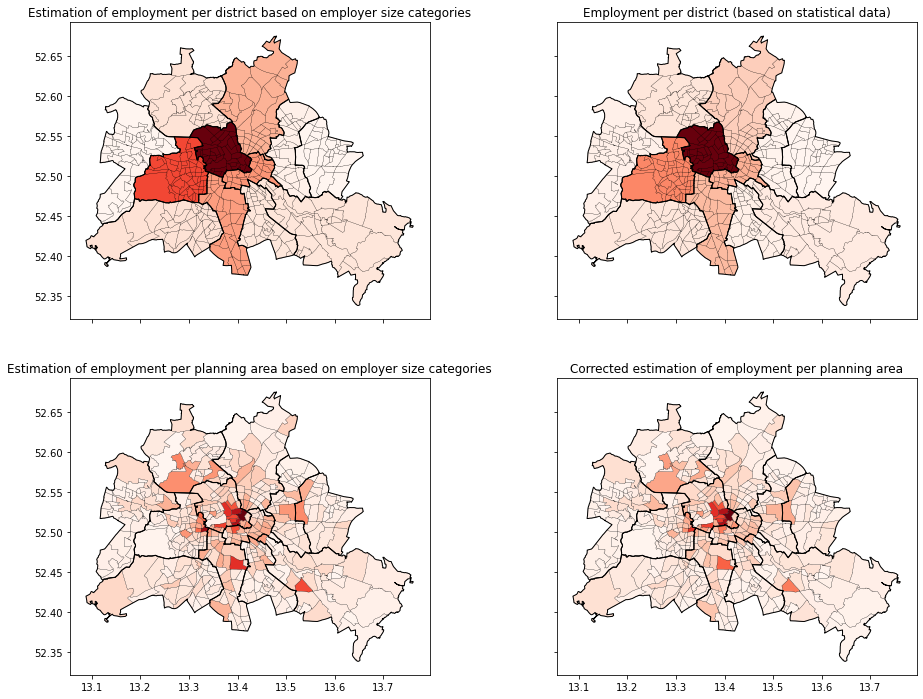

In [131]:
if show_plots:
    # this plot should be adapted to show the process. it could show the following:
    # employment data by district (Bezirk)
    # guess based on companies for plr
    # corrected guess for plr
    # employment per building 
    # employment per zone
    
    fig, ax = plt.subplots(2, 2, figsize=(16,12), sharex='all', sharey='all')

    bezirke.plot(ax=ax.flat[0], column='guess_sum', cmap="Reds", legend=False)
    bezirke.plot(ax=ax.flat[1], column='real_employment', cmap="Reds", legend=False)
    sm.zones.plot(ax=ax.flat[2], column='emp_guess', cmap="Reds", legend=False)
    sm.zones.plot(ax=ax.flat[3], column='emp', cmap="Reds", legend=False)

    plr.plot(ax=ax.flat[0], color='None', edgecolor="black", linewidth=0.15)
    plr.plot(ax=ax.flat[1], color='None', edgecolor="black", linewidth=0.15)
    plr.plot(ax=ax.flat[2], color='None', edgecolor="black", linewidth=0.15)
    plr.plot(ax=ax.flat[3], color='None', edgecolor="black", linewidth=0.15)
    
    bezirke.plot(ax=ax.flat[0], color='None', edgecolor="black", linewidth=1)
    bezirke.plot(ax=ax.flat[1], color='None', edgecolor="black", linewidth=1)
    bezirke.plot(ax=ax.flat[2], color='None', edgecolor="black", linewidth=1)
    bezirke.plot(ax=ax.flat[3], color='None', edgecolor="black", linewidth=1)

    ax.flat[0].set_title("Estimation of employment per district based on employer size categories")
    ax.flat[1].set_title("Employment per district (based on statistical data)")
    ax.flat[2].set_title("Estimation of employment per planning area based on employer size categories")
    ax.flat[3].set_title("Corrected estimation of employment per planning area")


## Add demographic information

In [ ]:
age = pd.read_excel(input_path + 'sbb_alter10jahre.xlsx')
age_sex = pd.read_excel(input_path + 'sbb_alter10jahre_geschlecht.xlsx', header=[0,1])
age_sex.head()

alter unter 10          10 bis unter 20           \
                   geschlecht männlich weiblich        männlich weiblich   
0                      Berlin   184428   174889          159024   149941   
1       01011101 Stülerstraße      118      112              65       66   
2  01011102 Großer Tiergarten        3        3               7        3   
3       01011103 Lützowstraße      206      201             173      159   
4       01011104 Körnerstraße      220      220             226      227   

  20 bis unter 30          30 bis unter 40          40 bis unter 50  ...  \
         männlich weiblich        männlich weiblich        männlich  ...   
0          238238   237179          335671   322106          252495  ...   
1             355      321             326      333             263  ...   
2              22       13              26       13              14  ...   
3             468      367             530      394             336  ...   
4             595      413             507      425             382  ...   

  50 bis unter 60          60 bis unter 70          70 bis unter 80           \
         männlich weiblich        männlich weiblich        männlich weiblich   
0          275116   263228          194210   206956          140329   172453   
1             218      169             179      159             170      201   
2              21       15              12        6              13        -   
3             421      298             369      324             197      201   
4             346      248             182      149              81       77   

  80 bis unter 90          90 und mehr           
         männlich weiblich    männlich weiblich  
0           78110   117575        8614    22918  
1              90      102          12       12  
2               3        6           -        -  
3              71      138          12       42  
4              21       27           3       12  

[5 rows x 21 columns]

In [ ]:
age_sex[('10 bis unter 20', 'weiblich')]

0      149941
1          66
2           3
3         159
4         227
        ...  
444       782
445        89
446       383
447       213
448       319
Name: (10 bis unter 20, weiblich), Length: 449, dtype: object

### Next steps. Create attractor estimation.

Create attractor fields. <br>
Use school locations. (shapefile already there) <br>
Use Business locations (look up via OSM) <br>
Use Shopping locations (look up via OSM) <br>
Maybe use other data source like traffic data? <br>
Maybe use block height? <br>
Get Data on Mode Choice / Car Ownership for each zone? <br>

## Save model

In [ ]:
# remove additional geometry from dataframe, as otherwise an error is thrown when saving. 
sm.zones.drop(columns = [x for x in ['emp_guess'] if x in sm.zones.columns])

sm.zones = sm.zones.drop(columns = [x for x in ['popCentroid', 'popCentroidOffset'] if x in sm.zones.columns])

In [ ]:
# Saving model zones as geojson
sm.to_json(model_path + 'zones', only_attributes=['zones'], encoding='utf-8')

to_hdf(overwriting): 100%|██████████| 32/32 [00:01<00:00, 17.03it/s]
